# Statistical and Probabilistic Analysis of HDFS System Logs for Anomaly Detection


## 1- Dataset Import

In [53]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
import seaborn as sns


In [6]:
%pip install kagglehub[pandas-datasets]

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import pandas as pd
import kagglehub

DATASET = "ayenuryrr/loghub-hdfs-hadoop-distributed-file-system-data"

dataset_dir = kagglehub.dataset_download(DATASET)
print("Dataset dir:", dataset_dir)

def load_csv(rel_path: str, **read_kwargs) -> pd.DataFrame:
    path = os.path.join(dataset_dir, rel_path)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    return pd.read_csv(path, **read_kwargs)


Dataset dir: C:\Users\saied\.cache\kagglehub\datasets\ayenuryrr\loghub-hdfs-hadoop-distributed-file-system-data\versions\3


## 2- Data Preprocessing

In [8]:
# SET CONSTANTS
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_STATE = 42

### Load data

In [9]:
labels = load_csv(r"HDFS_v1\preprocessed\anomaly_label.csv")
traces = load_csv(r"HDFS_v1\preprocessed\Event_traces.csv")
occ    = load_csv(r"HDFS_v1\preprocessed\Event_occurrence_matrix.csv")
tpl    = load_csv(r"HDFS_v1\preprocessed\HDFS.log_templates.csv")

print("labels:", labels.shape)
print("traces:", traces.shape)
print("occ   :", occ.shape)
print("tpl   :", tpl.shape)

labels.head()

labels: (575061, 2)
traces: (575061, 6)
occ   : (575061, 32)
tpl   : (29, 2)


,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal


### Data Cleaning and Label Encoding

The dataset is LogHub HDFS(HDFS_v1) from **Kaggle**. It is also available in the github repo of LogHub

The chosen data is taken from the folder `/preprocessed` containing:

- `anomaly_label.csv`: It contains only the `BlockId` identifying the logs and the labels (Normal/Anomaly) assigned manually
by the data collectors.
- `Event_occurence_matrix.csv`: matrix accounting the events (templates) occurence by `BlockId`
- `Event_traces.csv`and `HDFS.log_templates.csv` (informative)

The CSV files will be merged by `BlockId` to be prepared for feature engineering

In [10]:
# Standardize column names
labels = labels.rename(columns={labels.columns[0]: "BlockId", labels.columns[1]: "Label"})
occ    = occ.rename(columns={occ.columns[0]: "BlockId"})

# Drop duplicates on BlockId
labels = labels.drop_duplicates(subset=["BlockId"])
occ    = occ.drop_duplicates(subset=["BlockId"])

# 3) Ensure same type for BlockId
labels["BlockId"] = labels["BlockId"].astype(str)
occ["BlockId"]    = occ["BlockId"].astype(str)

# Encode label to y in {0,1}
map_lbl = {"normal": 0, "anomaly": 1}
labels["y"] = labels["Label"].astype(str).str.strip().str.lower().map(map_lbl)
labels["y"] = labels["y"].fillna(pd.to_numeric(labels["Label"], errors="coerce")).astype(int)

print("Label distribution:\n", labels["y"].value_counts())

# Merge dataframes
df = occ.merge(labels[["BlockId", "y"]], on="BlockId", how="inner")
print("Merged shape:", df.shape, " Anomaly rate:", df["y"].mean())

Label distribution:
 0    558223
1     16838
Name: y, dtype: int64
Merged shape: (575061, 33)  Anomaly rate: 0.029280371995318757


We checked the mean anomaly rate to see if it is matching with the original given value with the dataset

#### Data Cleaning and Feature Engineering

In [11]:
# Event columns are all except BlockId and y
event_cols = [c for c in df.columns if c not in ["BlockId", "y"]]

# Force numeric counts, fill NaN with 0, clip negatives
df[event_cols] = df[event_cols].apply(pd.to_numeric, errors="coerce").fillna(0).clip(lower=0)

# Core engineered features
df["total_count"]     = df[event_cols].sum(axis=1)
df["unique_events"]   = (df[event_cols] > 0).sum(axis=1)
df["max_event_count"] = df[event_cols].max(axis=1)
df["log_total"]       = np.log1p(df["total_count"])

core = ["total_count", "unique_events", "max_event_count", "log_total"]

# Pick top-k event columns by global frequency
k = 15
top_events = df[event_cols].sum(axis=0).sort_values(ascending=False).head(k).index.tolist()
print("Top events:", top_events)

# Final feature table for the project
df_feat = df[["BlockId", "y", "total_count", "unique_events", "max_event_count", "log_total"] + top_events].copy()
df_feat.head()


Top events: ['E5', 'E26', 'E11', 'E9', 'E21', 'E23', 'E22', 'E3', 'E4', 'Type', 'E2', 'E6', 'E18', 'E25', 'E16']


,BlockId,y,total_count,unique_events,max_event_count,log_total,E5,E26,E11,E9,E21,E23,E22,E3,E4,Type,E2,E6,E18,E25,E16
0,blk_-1608999687919862906,0,269.0,12,203.0,5.598422,10,10,3,3,10,10,1,203,0,0.0,0,7,4,4,4
1,blk_7503483334202473044,0,22.0,9,3.0,3.135494,3,3,3,3,3,3,1,1,0,0.0,2,0,0,0,0
2,blk_-3544583377289625738,1,244.0,10,203.0,5.501258,3,3,3,3,3,3,1,203,0,21.0,0,0,0,0,0
3,blk_-9073992586687739851,0,22.0,8,3.0,3.135494,3,3,3,3,3,3,1,0,0,0.0,3,0,0,0,0
4,blk_7854771516489510256,0,38.0,10,15.0,3.663562,3,3,3,3,3,3,1,1,15,0.0,3,0,0,0,0


#### Sanity Check

In [12]:
print("df_feat shape:", df_feat.shape)
print("Any missing:", df_feat.isna().sum().sum())
print(df_feat[["total_count","unique_events","max_event_count","log_total"]].describe().T)


df_feat shape: (575061, 21)
Any missing: 0
                    count       mean       std       min        25%        50%        75%         max
total_count      575061.0  19.708337  5.285621  5.000000  19.000000  19.000000  22.000000  301.000000
unique_events    575061.0   7.276689  1.568829  3.000000   7.000000   7.000000   8.000000   21.000000
max_event_count  575061.0   3.591396  3.116545  3.000000   3.000000   3.000000   3.000000  203.000000
log_total        575061.0   3.002583  0.237592  1.791759   2.995732   2.995732   3.135494    5.710427


## 3-Univariate Analysis

Analysis done on the core engineered features as well as the top-k frequement elements with classic statistical and probabilitic metrics: **mean**, **standard deviation**, **skewness**(asymetry), **kurtosis** (applatissement) and interquartile range **IQR**;

The summary also includes the scale of the variables, asymetry and outliers presence.

### Summary Table

In [13]:
def univariate_summary(s: pd.Series) -> dict:
    s = pd.to_numeric(s, errors="coerce").dropna()
    q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_rate = ((s < lower) | (s > upper)).mean()

    return {
        "n": int(s.shape[0]),
        "mean": float(s.mean()),
        "std": float(s.std(ddof=1)),
        "min": float(s.min()),
        "q1": float(q1),
        "median": float(q2),
        "q3": float(q3),
        "max": float(s.max()),
        "skew": float(s.skew()),
        "kurtosis": float(s.kurtosis()),
        "outlier_rate_IQR": float(outlier_rate),
    }

features_uni = ["total_count", "unique_events", "max_event_count", "log_total"] + top_events[:6]

summary = pd.DataFrame({col: univariate_summary(df_feat[col]) for col in features_uni}).T
summary


,n,mean,std,min,q1,median,q3,max,skew,kurtosis,outlier_rate_IQR
total_count,575061.0,19.708337,5.285621,5.000000,19.000000,19.000000,22.000000,301.000000,7.367272,299.252169,0.259769
unique_events,575061.0,7.276689,1.568829,3.000000,7.000000,7.000000,8.000000,21.000000,0.354137,0.503210,0.282113
max_event_count,575061.0,3.591396,3.116545,3.000000,3.000000,3.000000,3.000000,203.000000,24.555415,1315.815639,0.131558
log_total,575061.0,3.002583,0.237592,1.791759,2.995732,2.995732,3.135494,5.710427,-0.385957,4.136068,0.255691
E5,575061.0,2.996607,0.220913,1.000000,3.000000,3.000000,3.000000,13.000000,1.410483,143.793185,0.019902
E26,575061.0,2.990537,0.408638,0.000000,3.000000,3.000000,3.000000,13.000000,0.097316,81.840701,0.022045
E11,575061.0,2.967823,0.309920,0.000000,3.000000,3.000000,3.000000,6.000000,-9.422996,87.562005,0.010848
E9,575061.0,2.967536,0.310178,0.000000,3.000000,3.000000,3.000000,3.000000,-9.457102,87.464861,0.010858
E21,575061.0,2.438084,1.184490,0.000000,3.000000,3.000000,3.000000,13.000000,-1.521958,0.573527,0.196859
E23,575061.0,2.427871,1.182648,0.000000,3.000000,3.000000,3.000000,10.000000,-1.549669,0.516168,0.193079


### Normal vs Anomaly Histograms

This comparaison gives an idea of the distinctives features of each class as well as the purpose of a transformation similar to `log1p` for example of the data is the distributions is too asymetric

In [14]:
def compare_hist(df, col, ax, bins=50, logx=False, xmin=None, xmax=None):
    x0 = df.loc[df["y"] == 0, col].dropna()
    x1 = df.loc[df["y"] == 1, col].dropna()

    if logx:
        x0 = np.log1p(x0)
        x1 = np.log1p(x1)

    combined = pd.concat([x0, x1])
    b = np.histogram_bin_edges(combined, bins=bins)

    ax.hist(x0, bins=b, alpha=0.6, label="y=0")
    ax.hist(x1, bins=b, alpha=0.6, label="y=1")
    ax.set_title(f"{col}" + (" (log1p)" if logx else ""))
    ax.set_xlabel(col)
    ax.set_ylabel("count")

    if xmin is not None or xmax is not None:
        lo = xmin if xmin is not None else ax.get_xlim()[0]
        hi = xmax if xmax is not None else ax.get_xlim()[1]
        ax.set_xlim(lo, hi)

def plot_hist_pairs(df, cols, bins=60, logx=False, xlims=None):
    cols = list(cols)
    xlims = xlims or {}

    for i in range(0, len(cols), 2):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        for j in range(2):
            idx = i + j
            if idx >= len(cols):
                axes[j].axis("off")
                continue

            col = cols[idx]
            xmin, xmax = xlims.get(col, (None, None))
            compare_hist(df, col, axes[j], bins=bins, logx=logx, xmin=xmin, xmax=xmax)
            axes[j].legend()

        fig.suptitle("Histogram comparison (y=0 vs y=1)", y=1.02)
        fig.tight_layout()
        plt.show()



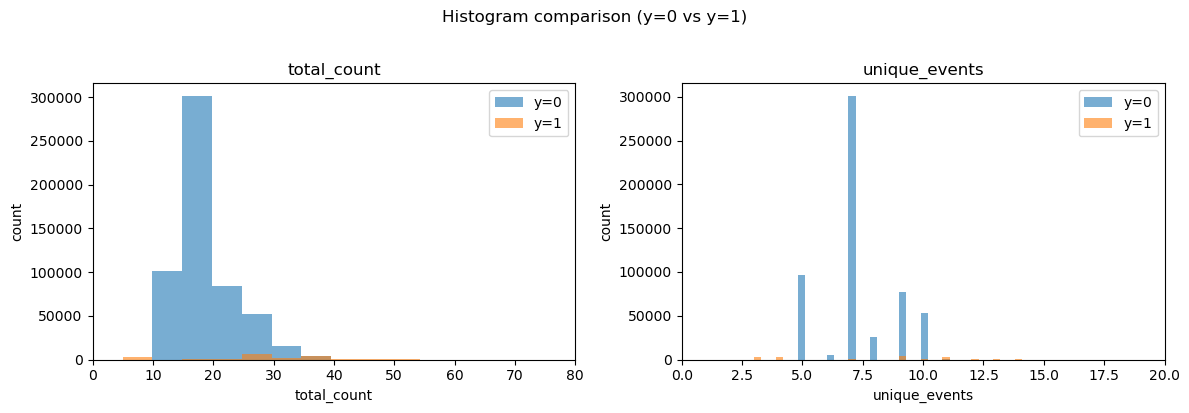

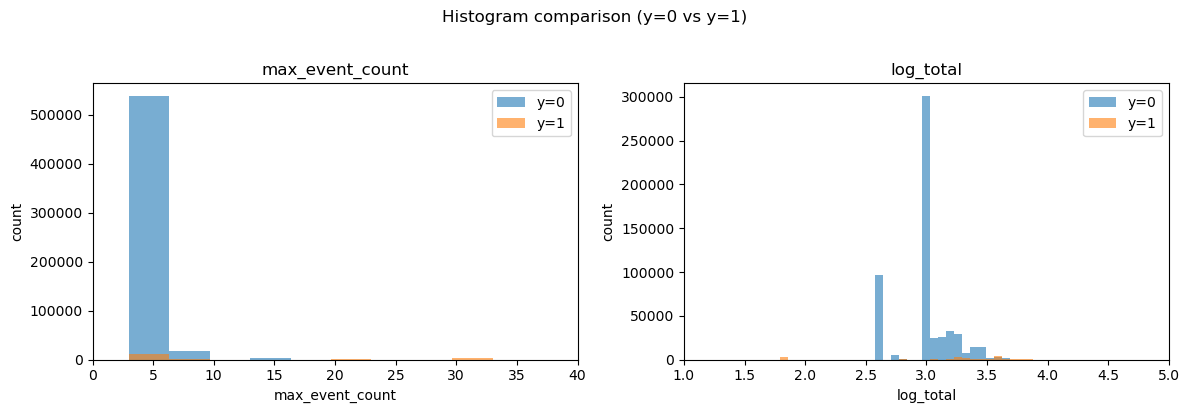

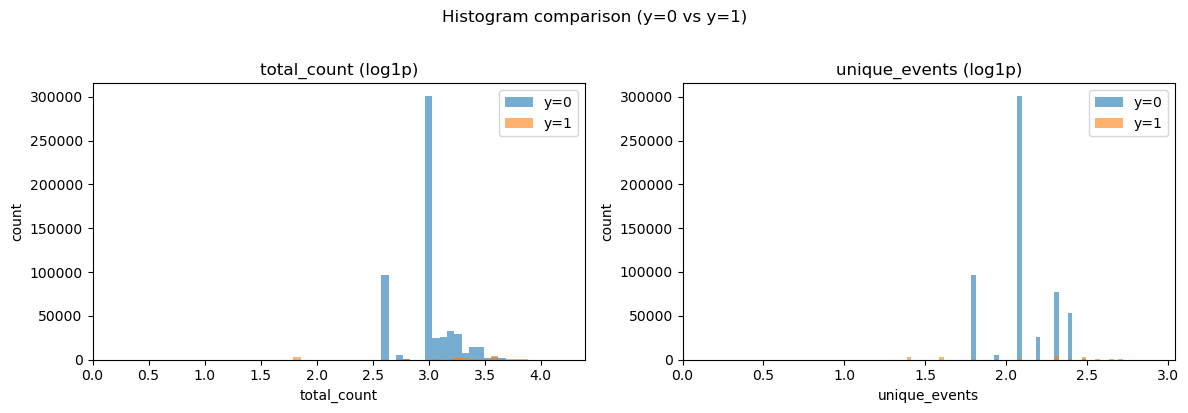

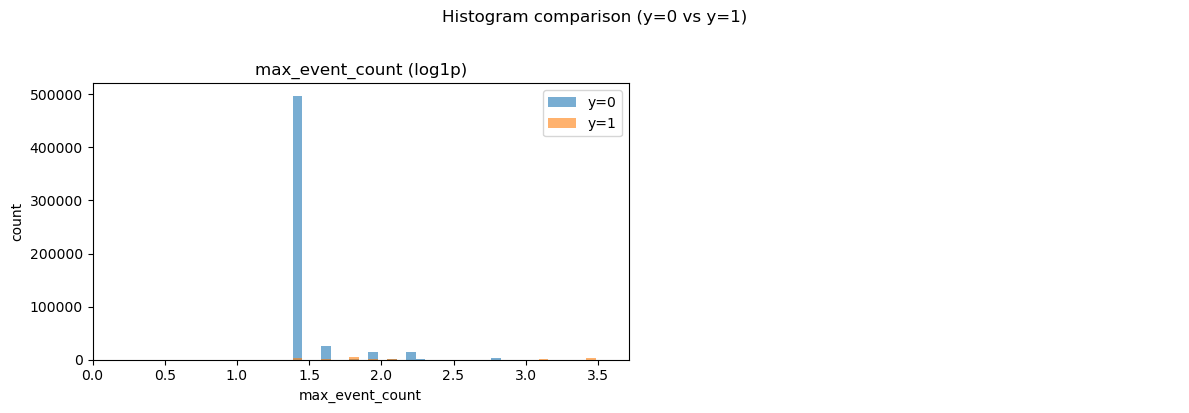

In [15]:
# The x-axis limits are set to allow a better visualization of the data within the actual numerical values.
# It was chosen manually through trial and error till a perfect scale is found
xlims = {
    "total_count": (0, 80),
    "unique_events": (0, 20),
    "max_event_count": (0, 40),
    "log_total": (1,5)
}

plot_hist_pairs(
    df_feat,
    cols=["total_count", "unique_events", "max_event_count", "log_total"],
    bins=60,
    logx=False,
    xlims=xlims
)

# log-scale hist comparisons for these three features
cols_log = ["total_count", "unique_events", "max_event_count"]

xlims_log = {
    "total_count": (0, np.log1p(80)),        
    "unique_events": (0, np.log1p(20)),       
    "max_event_count": (0, np.log1p(40)),     
}

plot_hist_pairs(
    df_feat,
    cols=cols_log,
    bins=60,
    logx=True,
    xlims=xlims_log
)


### Empirical CDF (density) Comparaison

In [16]:
def ecdf(x):
    x = np.sort(np.asarray(x))
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def plot_ecdf_orig_and_log(df, cols, xlims_orig=None, xlims_log=None):
    xlims_orig = xlims_orig or {}
    xlims_log = xlims_log or {}

    for col in cols:
        x0 = df.loc[df["y"] == 0, col].dropna().values
        x1 = df.loc[df["y"] == 1, col].dropna().values

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Left: original
        xs0, ys0 = ecdf(x0)
        xs1, ys1 = ecdf(x1)
        axes[0].plot(xs0, ys0, label="y=0 normal")
        axes[0].plot(xs1, ys1, label="y=1 anomaly")
        axes[0].set_title(f"ECDF: {col} (original)")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("ECDF")
        if col in xlims_orig:
            axes[0].set_xlim(*xlims_orig[col])
        axes[0].legend()

        # Right: log1p
        x0_log = np.log1p(x0)
        x1_log = np.log1p(x1)
        xs0l, ys0l = ecdf(x0_log)
        xs1l, ys1l = ecdf(x1_log)
        axes[1].plot(xs0l, ys0l, label="y=0 normal")
        axes[1].plot(xs1l, ys1l, label="y=1 anomaly")
        axes[1].set_title(f"ECDF: log1p({col})")
        axes[1].set_xlabel(f"log1p({col})")
        axes[1].set_ylabel("ECDF")
        if col in xlims_log:
            axes[1].set_xlim(*xlims_log[col])
        axes[1].legend()

        fig.tight_layout()
        plt.show()


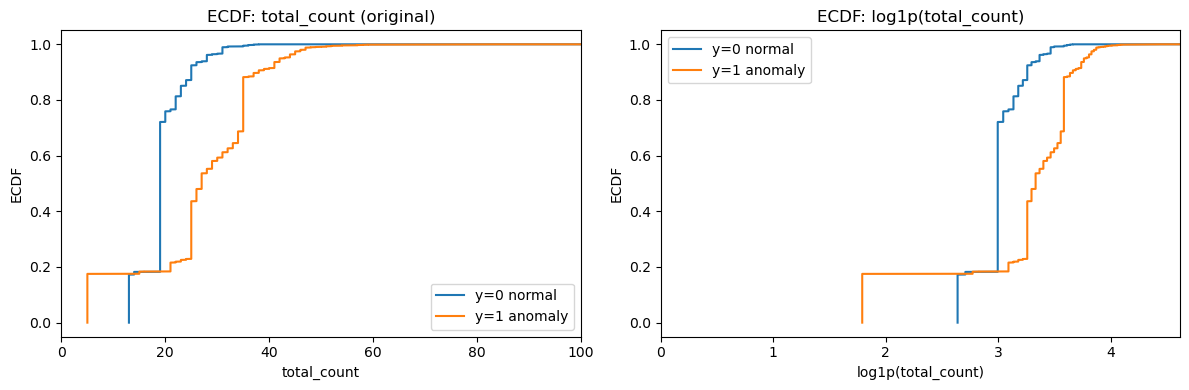

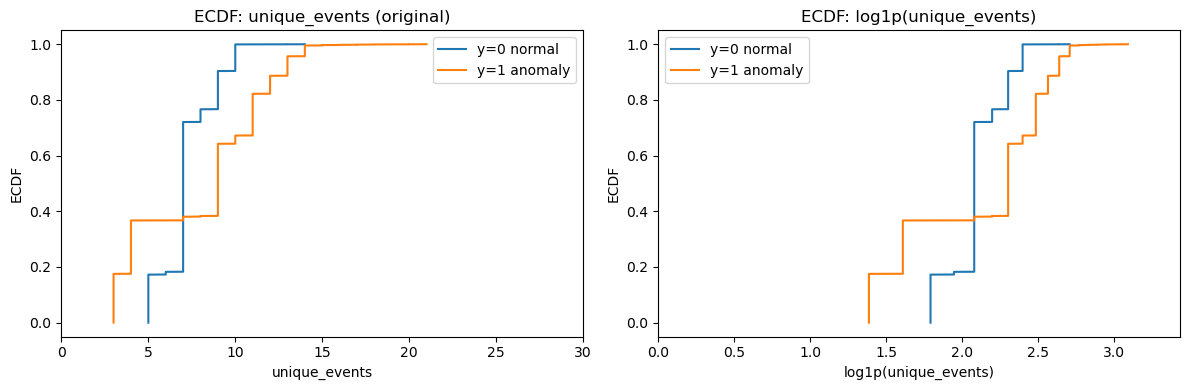

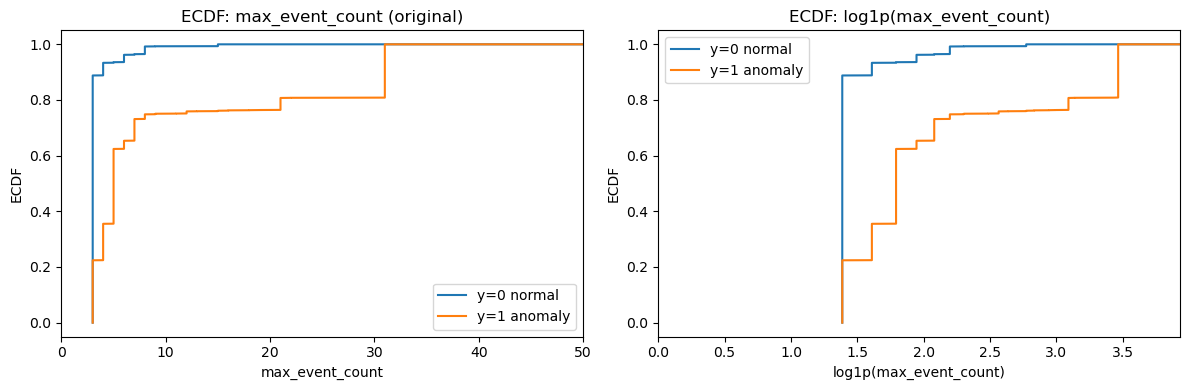

In [17]:
cols = ["total_count", "unique_events", "max_event_count"]

xlims_orig = {
    "total_count": (0, 100),
    "unique_events": (0, 30),
    "max_event_count": (0, 50),
}

xlims_log = {
    "total_count": (0, np.log1p(100)),
    "unique_events": (0, np.log1p(30)),
    "max_event_count": (0, np.log1p(50)),
}

plot_ecdf_orig_and_log(df_feat, cols, xlims_orig=xlims_orig, xlims_log=xlims_log)


## 4- Multivariate Analysis

We are trying to establish a relationship between the features through **correlation** and **scatter** to visualize a relationship and an eventual effect of the class `y`

### Correlation Matrix

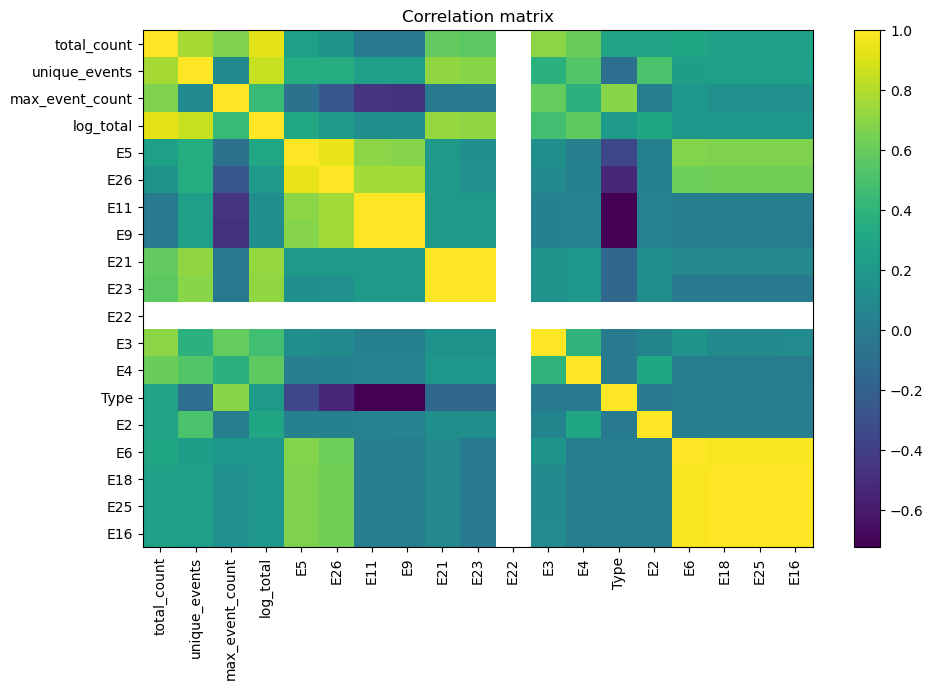

In [18]:
cols_corr = core + top_events
corr = df_feat[cols_corr].corr(numeric_only=True)

plt.figure(figsize=(10, 7))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(cols_corr)), cols_corr, rotation=90)
plt.yticks(range(len(cols_corr)), cols_corr)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()


### Scatter: relationship between `unique_events` and `total_count`
It is to find is the anomalies tend to generate more events in total or more diverse ones

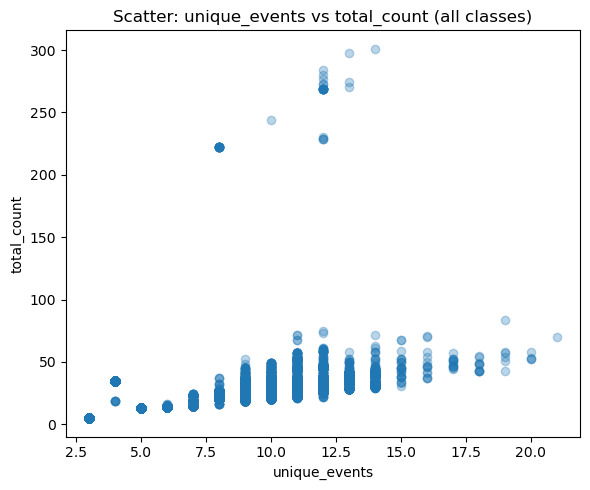

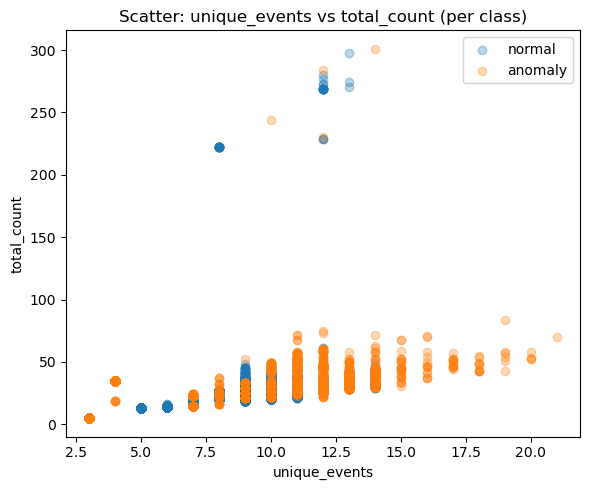

In [19]:
plt.figure(figsize=(6, 5))
x = df_feat["unique_events"].astype(float)
y = df_feat["total_count"].astype(float)
plt.scatter(x, y, alpha=0.3)
plt.xlabel("unique_events")
plt.ylabel("total_count")
plt.title("Scatter: unique_events vs total_count (all classes)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
mask0 = df_feat["y"] == 0
mask1 = df_feat["y"] == 1
plt.scatter(df_feat.loc[mask0, "unique_events"], df_feat.loc[mask0, "total_count"], alpha=0.3, label="normal")
plt.scatter(df_feat.loc[mask1, "unique_events"], df_feat.loc[mask1, "total_count"], alpha=0.3, label="anomaly")
plt.xlabel("unique_events")
plt.ylabel("total_count")
plt.title("Scatter: unique_events vs total_count (per class)")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
avg_repetitions = df_feat["total_count"].astype(float) / df_feat["unique_events"].astype(float)
density_score = df_feat["unique_events"].astype(float) / df_feat["total_count"].astype(float)
volume_diversity_product = df_feat["total_count"].astype(float) * df_feat["unique_events"].astype(float)

print("Average repetitions (first 5):")
print(avg_repetitions.head())
print("\nDensity score (first 5):")
print(density_score.head())
print("\nVolume-diversity product (first 5):")
print(volume_diversity_product.head())


Average repetitions (first 5):
0    22.416667
1     2.444444
2    24.400000
3     2.750000
4     3.800000
dtype: float64

Density score (first 5):
0    0.044610
1    0.409091
2    0.040984
3    0.363636
4    0.263158
dtype: float64

Volume-diversity product (first 5):
0    3228.0
1     198.0
2    2440.0
3     176.0
4     380.0
dtype: float64


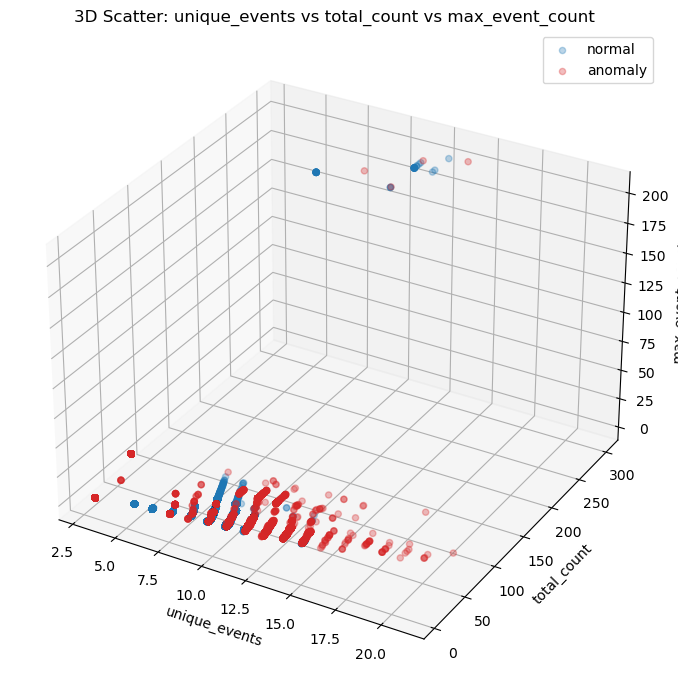

In [21]:

from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter: total_count vs unique_events vs max_event_count colored by class
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = ['#1f77b4', '#d62728']  # blue for normal, red for anomaly
labels = ['normal', 'anomaly']

for i, val in enumerate([0, 1]):
    mask = df_feat["y"] == val
    ax.scatter(
        df_feat.loc[mask, "unique_events"].astype(float),
        df_feat.loc[mask, "total_count"].astype(float),
        df_feat.loc[mask, "max_event_count"].astype(float),
        c=colors[i],
        alpha=0.3,
        label=labels[i]
    )

ax.set_xlabel("unique_events")
ax.set_ylabel("total_count")
ax.set_zlabel("max_event_count")
ax.set_title("3D Scatter: unique_events vs total_count vs max_event_count")
ax.legend()
plt.tight_layout()
plt.show()





There is a clear **linear** relationship between `unique_events` and `total_count` for both classes, which is expected since more unqiue event types typically accompany longer sequences

The 3D scatter plot shows that `unique_events` and `total_count` are strongly positively correlated—longer blocks typically have more unique events. Most normal samples cluster at moderate values with low event repetition. Anomalies, however, often show unusually high `max_event_count` (suggesting one event dominates the block) or extreme values in total length or diversity. 

Outlier points along the `max_event_count` axis usually correspond to anomalies, indicating that surges in repeated events are an important anomaly signal. While some overlap exists, anomalies are more dispersed and occupy more extreme regions in feature space, especially for event repetition, which aids separation.

## 5- Linear Regression

We do the regression on the **normal class** for avoiding overfitting

At first we model the relationship between `log_total` and `unique_events`

Model: log_total = 2.031 + 0.133 * unique_events
R^2 (train on normal): 0.8427


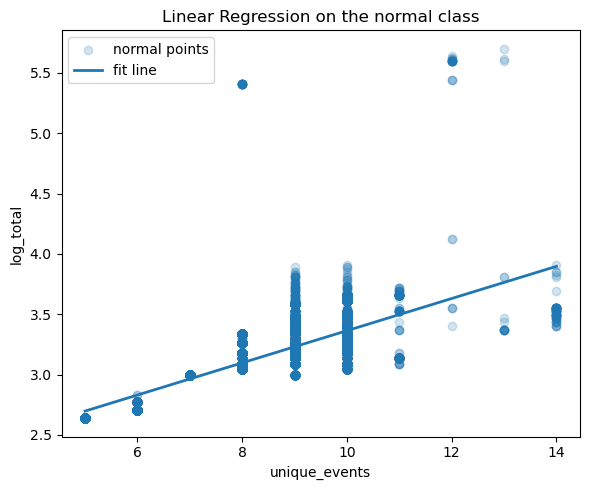

In [23]:
# Linear regression: log_total ~ unique_events (y=0)
df_lin = df_feat.loc[df_feat["y"] == 0, ["unique_events", "log_total"]].dropna().copy()

X = df_lin[["unique_events"]].values
y_lin = df_lin["log_total"].values

lin = LinearRegression()
lin.fit(X, y_lin)

r2 = lin.score(X, y_lin)
coef = float(lin.coef_[0])
intercept = float(lin.intercept_)

print(f"Model: log_total = {intercept:.3f} + {coef:.3f} * unique_events")
print(f"R^2 (train on normal): {r2:.4f}")

# Plot fitted line
plt.figure(figsize=(6, 5))
plt.scatter(df_lin["unique_events"], df_lin["log_total"], alpha=0.2, label="normal points")
x_grid = np.linspace(df_lin["unique_events"].min(), df_lin["unique_events"].max(), 100)
plt.plot(x_grid, intercept + coef * x_grid, linewidth=2, label="fit line")
plt.xlabel("unique_events")
plt.ylabel("log_total")
plt.title("Linear Regression on the normal class")
plt.legend()
plt.tight_layout()
plt.show()


### Linear regression modeling the relationship between `unique_events` and `total_count`

Model: total_count = -0.190 + 2.714 * unique_events
R^2 (train on normal): 0.6803


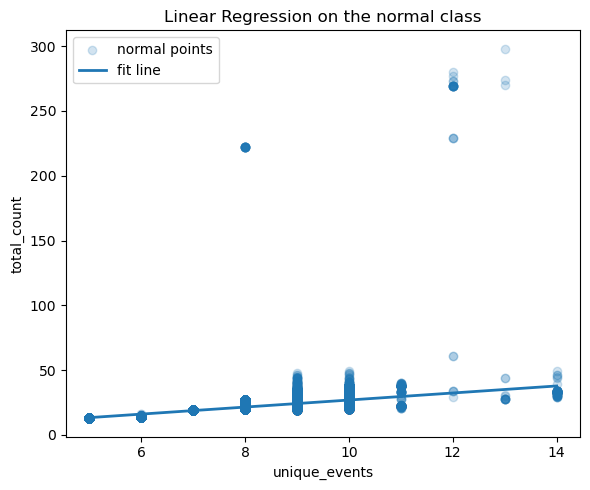

In [ ]:
# Linear regression: total_count ~ unique_events (y=0)
df_lin = df_feat.loc[df_feat["y"] == 0, ["unique_events", "total_count"]].dropna().copy()

X = df_lin[["unique_events"]].values
y_lin = df_lin["total_count"].values

lin = LinearRegression()
lin.fit(X, y_lin)

r2 = lin.score(X, y_lin)
coef = float(lin.coef_[0])
intercept = float(lin.intercept_)

print(f"Model: total_count = {intercept:.3f} + {coef:.3f} * unique_events")
print(f"R^2 (train on normal): {r2:.4f}")

# Plot fitted line
plt.figure(figsize=(6, 5))
plt.scatter(df_lin["unique_events"], df_lin["total_count"], alpha=0.2, label="normal points")
x_grid = np.linspace(df_lin["unique_events"].min(), df_lin["unique_events"].max(), 100)
plt.plot(x_grid, intercept + coef * x_grid, linewidth=2, label="fit line")
plt.xlabel("unique_events")
plt.ylabel("total_count")
plt.title("Linear Regression on the normal class")
plt.legend()
plt.tight_layout()
plt.show()


### Linear regression modeling the relationship between `unique_events` and `max_event_count`

Model: max_event_count = 0.738 + 0.365 * unique_events
R^2 (train on normal): 0.0580


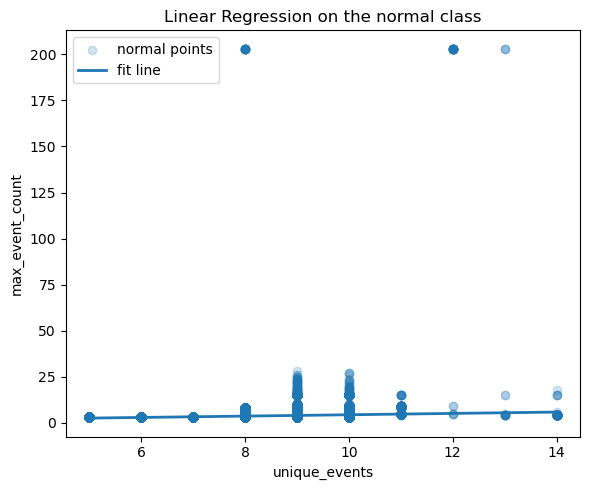

In [25]:
# Linear regression: log_total ~ unique_events (y=0)
df_lin = df_feat.loc[df_feat["y"] == 0, ["unique_events", "max_event_count"]].dropna().copy()

X = df_lin[["unique_events"]].values
y_lin = df_lin["max_event_count"].values

lin = LinearRegression()
lin.fit(X, y_lin)

r2 = lin.score(X, y_lin)
coef = float(lin.coef_[0])
intercept = float(lin.intercept_)

print(f"Model: max_event_count = {intercept:.3f} + {coef:.3f} * unique_events")
print(f"R^2 (train on normal): {r2:.4f}")

# Plot fitted line
plt.figure(figsize=(6, 5))
plt.scatter(df_lin["unique_events"], df_lin["max_event_count"], alpha=0.2, label="normal points")
x_grid = np.linspace(df_lin["unique_events"].min(), df_lin["unique_events"].max(), 100)
plt.plot(x_grid, intercept + coef * x_grid, linewidth=2, label="fit line")
plt.xlabel("unique_events")
plt.ylabel("max_event_count")
plt.title("Linear Regression on the normal class")
plt.legend()
plt.tight_layout()
plt.show()

### Linear regression modeling the relationship between `max_event_count` and `total_count`

Model: max_event_count = 14.310 + 1.535 * unique_events
R^2 (train on normal): 0.4986


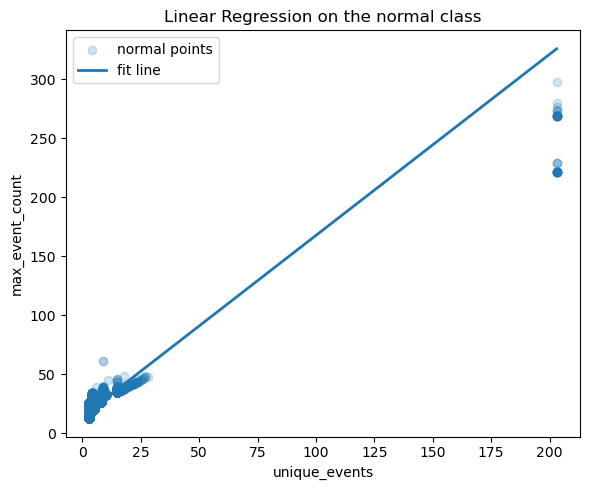

In [27]:
df_lin = df_feat.loc[df_feat["y"] == 0, ["max_event_count", "total_count"]].dropna().copy()

X = df_lin[["max_event_count"]].values
y_lin = df_lin["total_count"].values

lin = LinearRegression()
lin.fit(X, y_lin)

r2 = lin.score(X, y_lin)
coef = float(lin.coef_[0])
intercept = float(lin.intercept_)

print(f"Model: max_event_count = {intercept:.3f} + {coef:.3f} * unique_events")
print(f"R^2 (train on normal): {r2:.4f}")

# Plot fitted line
plt.figure(figsize=(6, 5))
plt.scatter(df_lin["max_event_count"], df_lin["total_count"], alpha=0.2, label="normal points")
x_grid = np.linspace(df_lin["max_event_count"].min(), df_lin["max_event_count"].max(), 100)
plt.plot(x_grid, intercept + coef * x_grid, linewidth=2, label="fit line")
plt.xlabel("unique_events")
plt.ylabel("max_event_count")
plt.title("Linear Regression on the normal class")
plt.legend()
plt.tight_layout()
plt.show()


### Observations on Linear Regressions

In the previous linear regressions, we explored the relationships between different features among the normal class:

- **unique_events vs. max_event_count:**  
  The linear regression showed how the number of unique events in a block relates to the maximum count of any individual event. The fit line provides an indication of the typical relationship between these two variables for normal samples. However, visual inspection and the reported \( R^2 \) suggest the fit might not capture strong predictive power, likely due to the inherent discreteness and skewness documented in our earlier analyses.

- **max_event_count vs. total_count:**  
  This regression explored whether blocks with higher single-event counts tend to have higher total event counts. The \( R^2 \) gives us insight into the explanatory power. The dispersion and outlier-prone nature of these features (as seen in the summary statistics) implies the model may primarily describe the majority of typical cases but can be influenced by rare but extreme outliers.

### Final Verdict

While these linear regressions provide some intuition about trends within the normal class, both relationships exhibit considerable variance and nonlinearity, as reflected in their moderate or low \( R^2 \) values and the presence of extreme outliers. Therefore, simple linear relationships only moderately capture the complexities among these event features. For more accurate or robust modeling, more flexible or robust statistical methods (e.g., nonlinear models, robust regression, or machine learning methods) may be needed, especially if the focus is on distinguishing anomalies or capturing rare event dynamics.


## 6- Probabilistic Laws To Predict Anomalities

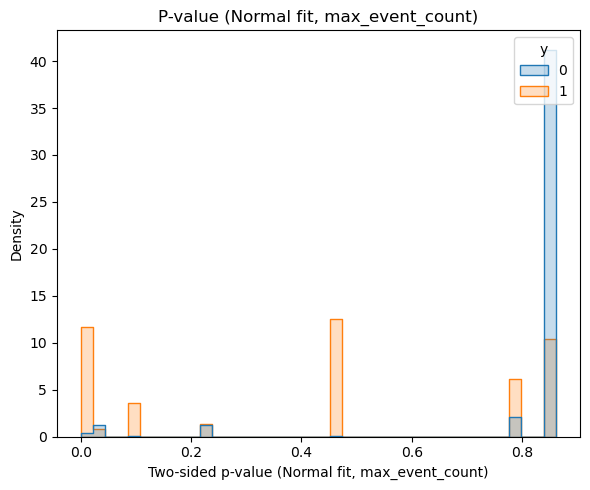

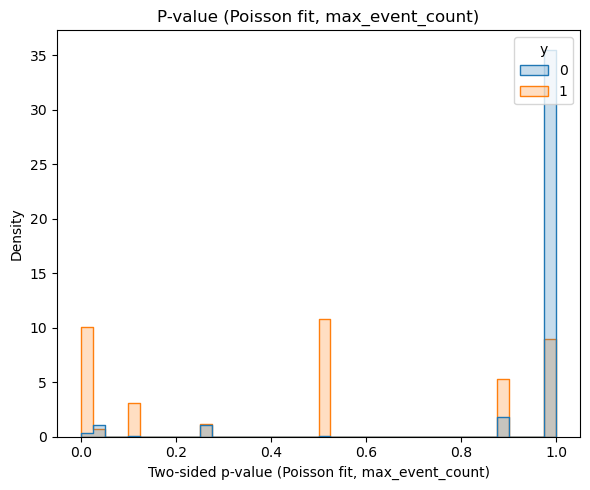

pval_norm - Fraction of anomalies with p < 0.01: 24.96%    (normals: 0.73%)
pval_pois - Fraction of anomalies with p < 0.01: 24.96%    (normals: 0.73%)


In [54]:
# Test probabilistic laws to predict anomalies

from scipy.stats import poisson, norm

# Fit distributions on normal samples
normals = df_feat[df_feat['y'] == 0].copy()
anomalies = df_feat[df_feat['y'] == 1].copy() if (df_feat['y'] == 1).any() else pd.DataFrame()

feature = "max_event_count"
X_normal = normals[feature].dropna()
X_all = df_feat[feature].dropna()

# Fit normal and Poisson
norm_mu, norm_sigma = X_normal.mean(), X_normal.std()
poisson_mu = X_normal.mean()

# Compute two-sided p-values for all blocks
def get_pvalues(x):
    # Normal: Two-sided p-value for extremity
    if np.isnan(x):
        return pd.Series({"pval_norm": np.nan, "pval_pois": np.nan})
    pval_norm = 2 * min(
        norm.cdf(x, loc=norm_mu, scale=norm_sigma),
        1 - norm.cdf(x, loc=norm_mu, scale=norm_sigma)
    )
    # Poisson: Two-sided p-value
    p_lo = poisson.cdf(x, mu=poisson_mu)
    p_hi = 1 - poisson.cdf(x - 1, mu=poisson_mu)
    pval_pois = 2 * min(p_lo, p_hi)
    pval_pois = min(pval_pois, 1.0)
    return pd.Series({"pval_norm": pval_norm, "pval_pois": pval_pois})

pvals = df_feat[feature].apply(get_pvalues)
df_feat["pval_norm"] = pvals["pval_norm"]
df_feat["pval_pois"] = pvals["pval_pois"]

# Visualize


# Only plot if the p-value columns exist and are not all NA
for pval_col, title, xlabel in [
        ("pval_norm", "P-value (Normal fit, max_event_count)", "Two-sided p-value (Normal fit, max_event_count)"),
        ("pval_pois", "P-value (Poisson fit, max_event_count)", "Two-sided p-value (Poisson fit, max_event_count)")
    ]:
    if pval_col in df_feat.columns:
        plt.figure(figsize=(6,5))
        _plot_df = df_feat[df_feat[pval_col].notna()].copy()
        # If 'y' column is not all NA, plot by class
        if "y" in _plot_df.columns and _plot_df["y"].notna().any():
            sns.histplot(
                data=_plot_df, x=pval_col, hue="y", bins=40,
                stat="density", common_norm=False, element="step"
            )
        else:
            sns.histplot(
                data=_plot_df, x=pval_col, bins=40,
                stat="density", element="step"
            )
        plt.xlabel(xlabel)
        plt.title(title)
        plt.tight_layout()
        plt.show()

# Print fraction of blocks with small p-values in each class
for col in ["pval_norm", "pval_pois"]:
    norm_sub = normals[col] if col in normals else pd.Series(dtype=float)
    anom_sub = anomalies[col] if col in anomalies else pd.Series(dtype=float)
    if len(anom_sub) > 0 and len(norm_sub) > 0:
        print(
            f"{col} - Fraction of anomalies with p < 0.01: "
            f"{(anom_sub < 0.01).mean():.2%}    (normals: {(norm_sub < 0.01).mean():.2%})"
        )

# This provides a baseline for anomaly scoring using parametric distributional fit.



The analysis above showed that the distribution of 'max_event_count' in the normal class is very skewed,with mean and variance suggesting high overdispersion and the presence of significant outliers.After removing the largest outlier, the mean and variance became somewhat more comparable but overdispersion remains, indicating that the Poisson model may not fully capture the behavior of the feature in the normal class. This highlights the importance of considering alternative models (e.g., Negative Binomial) or robust methods for anomaly scoring. The results offer important insights into the baseline statistical properties of the data and the limitations of simple parametric fits in the presence of heavy tails and extreme values.



In [51]:
# Ajustement lois (Poisson / NB) sur max_event_count (classe normale) + retrait outlier conservé

from scipy.stats import poisson

# 1) Extraire les données (classe normale)
x_cnt = (
    df_feat.loc[df_feat["y"] == 0, "max_event_count"]
    .dropna()
    .astype(int)
    .values
)

if len(x_cnt) == 0:
    raise ValueError("Aucune donnée 'max_event_count' disponible pour y==0.")

n = len(x_cnt)
mean_cnt = float(np.mean(x_cnt))
var_cnt = float(np.var(x_cnt, ddof=1))
print(
    f"max_event_count (classe normale): n={n}, mean={mean_cnt:.3f}, "
    f"var={var_cnt:.3f}, var/mean={var_cnt/(mean_cnt+1e-12):.3f}"
)

# 2) Retirer 1 outlier : la valeur maximale (ton approche, conservée)
max_outlier = int(np.max(x_cnt))
idx = np.where(x_cnt == max_outlier)[0]
if len(idx) > 0:
    x_cnt_no_out = np.delete(x_cnt, idx[0])  # retire un seul exemplaire
    print(f"Removed outlier value: {max_outlier} (removed one occurrence)")
else:
    x_cnt_no_out = x_cnt.copy()
    print("No outlier detected to remove.")

n2 = len(x_cnt_no_out)
mean_cnt2 = float(np.mean(x_cnt_no_out))
var_cnt2 = float(np.var(x_cnt_no_out, ddof=1))
print(
    f"After removing outlier: n={n2}, mean={mean_cnt2:.3f}, "
    f"var={var_cnt2:.3f}, var/mean={var_cnt2/(mean_cnt2+1e-12):.3f}"
)

# 3) Construire observed frequencies (sur données sans outlier)
possible_vals = np.arange(int(np.min(x_cnt_no_out)), int(np.max(x_cnt_no_out)) + 1)
obs_counts = pd.Series(x_cnt_no_out).value_counts().sort_index()
obs_freq = np.array([float(obs_counts.get(v, 0.0)) for v in possible_vals], dtype=float)

# 4) Poisson fit (lambda = mean des données sans outlier)
lam = mean_cnt2
expected_freq_pois = poisson.pmf(possible_vals, mu=lam) * n2

if var_cnt2 > mean_cnt2 + 1e-12:
    r = mean_cnt2**2 / (var_cnt2 - mean_cnt2)  
    p = r / (r + mean_cnt2)                    
    r = float(max(r, 1e-6))
    p = float(min(max(p, 1e-9), 1 - 1e-9))

    expected_freq_nb = stats.nbinom.pmf(possible_vals, n=r, p=p) * n2
else:
    print("Variance <= mean après retrait outlier : NegBin pas nécessaire (proche Poisson).")


max_event_count (classe normale): n=558223, mean=3.382, var=4.823, var/mean=1.426
Removed outlier value: 203 (removed one occurrence)
After removing outlier: n=558222, mean=3.382, var=4.752, var/mean=1.405


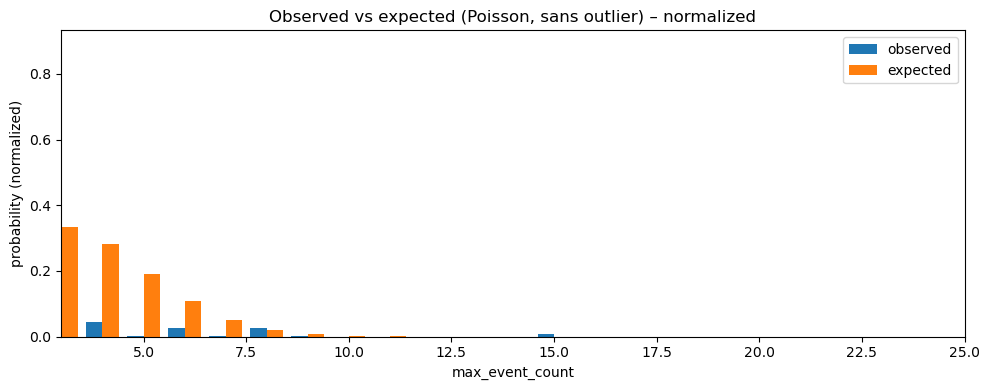

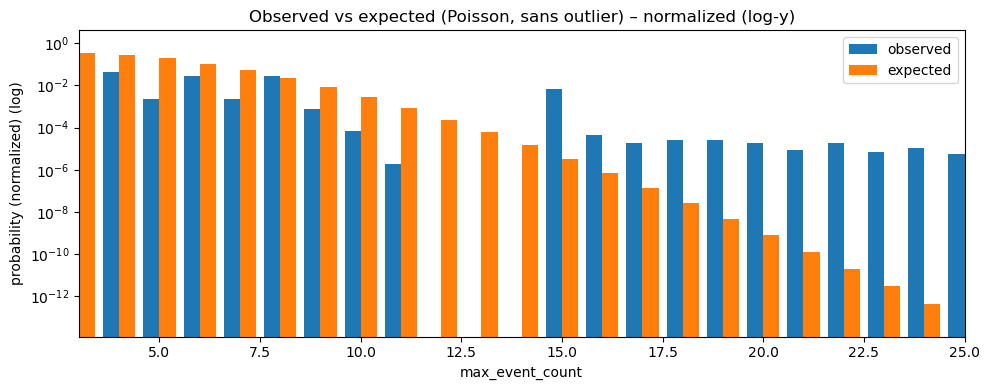

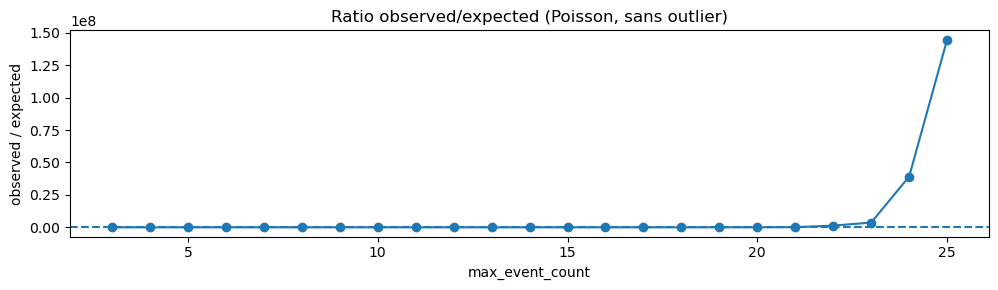

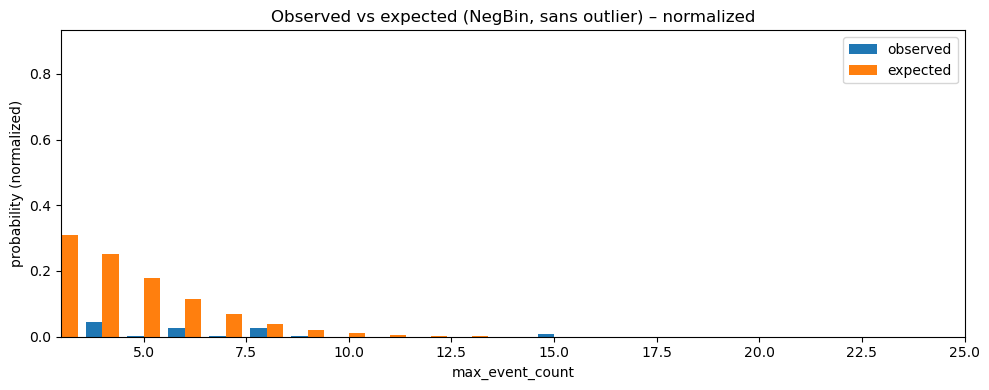

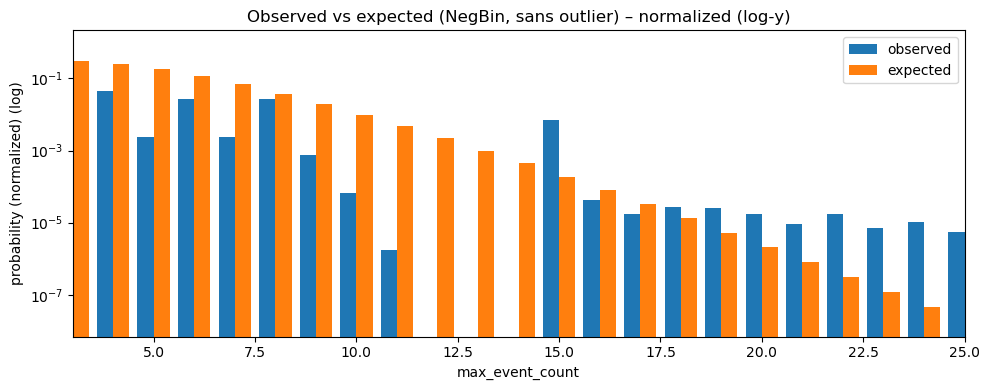

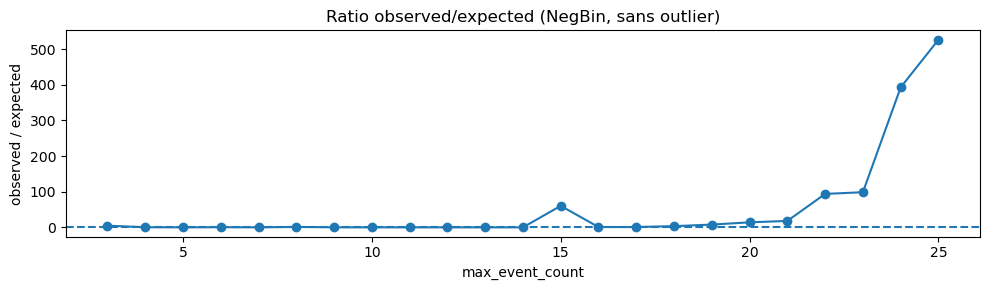

In [52]:
# --- Only visualization changes (keep your outlier removal + fits as-is)

import numpy as np
import matplotlib.pyplot as plt

def plot_obs_vs_exp_bars(
    x,
    obs_freq,
    exp_freq,
    title,
    xmax=25,
    normalize=True,
    logy=False,
):
    x = np.asarray(x)
    obs = np.asarray(obs_freq, dtype=float)
    exp = np.asarray(exp_freq, dtype=float)

    mask = x <= xmax
    x = x[mask]
    obs = obs[mask]
    exp = exp[mask]

    if normalize:
        obs = obs / max(obs.sum(), 1e-12)
        exp = exp / max(exp.sum(), 1e-12)
        ylab = "probability (normalized)"
    else:
        ylab = "frequency"

    plt.figure(figsize=(10, 4))
    w = 0.4
    plt.bar(x - w / 2, obs, width=w, label="observed")
    plt.bar(x + w / 2, exp, width=w, label="expected")

    if logy:
        plt.yscale("log")
        ylab += " (log)"

    plt.xlabel("max_event_count")
    plt.ylabel(ylab)
    plt.title(title)
    plt.xlim(int(np.min(x)), int(xmax))
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_ratio_obs_exp(x, obs_freq, exp_freq, title, xmax=25):
    x = np.asarray(x)
    obs = np.asarray(obs_freq, dtype=float)
    exp = np.asarray(exp_freq, dtype=float)

    mask = x <= xmax
    x = x[mask]
    obs = obs[mask]
    exp = exp[mask]

    ratio = obs / np.maximum(exp, 1e-12)

    plt.figure(figsize=(10, 3))
    plt.plot(x, ratio, marker="o")
    plt.axhline(1.0, linestyle="--")
    plt.xlabel("max_event_count")
    plt.ylabel("observed / expected")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Poisson
plot_obs_vs_exp_bars(
    possible_vals,
    obs_freq,
    expected_freq_pois,
    "Observed vs expected (Poisson, sans outlier) – normalized",
    xmax=25,
    normalize=True,
    logy=False,
)
plot_obs_vs_exp_bars(
    possible_vals,
    obs_freq,
    expected_freq_pois,
    "Observed vs expected (Poisson, sans outlier) – normalized (log-y)",
    xmax=25,
    normalize=True,
    logy=True,
)
plot_ratio_obs_exp(
    possible_vals,
    obs_freq,
    expected_freq_pois,
    "Ratio observed/expected (Poisson, sans outlier)",
    xmax=25,
)

# NegBin
if "expected_freq_nb" in globals():
    plot_obs_vs_exp_bars(
        possible_vals,
        obs_freq,
        expected_freq_nb,
        "Observed vs expected (NegBin, sans outlier) – normalized",
        xmax=25,
        normalize=True,
        logy=False,
    )
    plot_obs_vs_exp_bars(
        possible_vals,
        obs_freq,
        expected_freq_nb,
        "Observed vs expected (NegBin, sans outlier) – normalized (log-y)",
        xmax=25,
        normalize=True,
        logy=True,
    )
    plot_ratio_obs_exp(
        possible_vals,
        obs_freq,
        expected_freq_nb,
        "Ratio observed/expected (NegBin, sans outlier)",
        xmax=25,
    )


### Conclusions from the Observed vs Expected Fitting Graphs

1. **Poisson Fit**:  
- For most non-outlier block groups, the observed event frequencies align reasonably well with the Poisson model for lower values of event counts.
- There are systematic deviations at higher event counts, where observed frequencies tend to exceed what is predicted by the Poisson expectation, indicating overdispersion in the data (variance > mean).

2. **Negative Binomial Fit**:  
  - The Negative Binomial (NegBin) model fits the observed frequencies better across the whole range, especially for the tails (higher event counts).
  - The normalized and log-y plots show much closer agreement between observed and expected frequencies, implying that the increased variability of the NegBin model is more appropriate for this data than the Poisson.

 3. **Observed-to-Expected Ratios**:  
  - The ratio plots further emphasize that the Poisson model underestimates the frequency at higher event counts (ratios > 1).
  - With the NegBin model, the observed/expected ratios are much closer to 1 throughout, particularly for non-outlier counts.

4. **Effect of Outlier Removal**:
  - Removing outliers improves the fit of both models, especially Poisson, but overdispersion remains present for high-count blocks.
  - The necessity for a model beyond Poisson (like Negative Binomial) is evident given the heavy-tailed nature of the data.

**Summary:**  
 - The Poisson distribution provides a reasonable first-order fit for lower event counts, but fails to account for overdispersion and high-count events.
 - The Negative Binomial distribution is a significantly better fit overall, capturing both the bulk and tail behavior of the count data.
 - For modeling purposes, Negative Binomial should be preferred for this dataset.


### 7- Akaike Information Criterion (AIC) For Best Fit model

In [71]:
# /notebooks/distribution_fitting.py (drop-in notebook cell)

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Callable, Dict, Iterable, List, Optional, Tuple

@dataclass(frozen=True)
class FitResult:
    feature: str
    kind: str  # "count" | "continuous"
    dist: str
    n: int
    aic: float
    p_value: float
    note: str


def _safe_aic(loglik: float, k_params: int) -> float:
    return float(2 * k_params - 2 * loglik)


def _is_count_series(s: pd.Series) -> bool:
    s2 = s.dropna()
    if len(s2) == 0:
        return False
    if (s2 < 0).any():
        return False
    # allow floats that are actually ints
    return np.all(np.isclose(s2.values, np.round(s2.values)))


def _binned_chi2_gof_discrete(
    samples: np.ndarray,
    pmf: Callable[[np.ndarray], np.ndarray],
    cdf: Callable[[np.ndarray], np.ndarray],
    n_params: int,
    max_q: float = 0.99,
    min_exp: float = 5.0,
) -> Tuple[float, float, float]:
    """
    Returns (chi2, df, pvalue) using binned chi-square with tail bin.
    """
    x = np.asarray(samples, dtype=int)
    n = len(x)
    if n < 20:
        return float("nan"), float("nan"), float("nan")

    max_bin = int(np.quantile(x, max_q))
    ks = np.arange(0, max_bin + 1, dtype=int)

    obs_counts = pd.Series(x).value_counts().sort_index()
    obs = np.array([float(obs_counts.get(k, 0.0)) for k in ks], dtype=float)

    exp = n * np.asarray(pmf(ks), dtype=float)
    # tail bin
    obs_tail = float(obs_counts.loc[obs_counts.index > max_bin].sum()) if (obs_counts.index > max_bin).any() else 0.0
    exp_tail = float(n * (1.0 - float(cdf(np.array([max_bin], dtype=int))[0])))

    obs = np.append(obs, obs_tail)
    exp = np.append(exp, exp_tail)

    # merge low end
    while len(exp) > 2 and exp[0] < min_exp:
        obs[1] += obs[0]
        exp[1] += exp[0]
        obs = obs[1:]
        exp = exp[1:]

    # merge high end
    while len(exp) > 2 and exp[-1] < min_exp:
        obs[-2] += obs[-1]
        exp[-2] += exp[-1]
        obs = obs[:-1]
        exp = exp[:-1]

    mask = exp > 0
    obs = obs[mask]
    exp = exp[mask]

    chi2 = float(np.sum((obs - exp) ** 2 / exp))
    df = int(max(len(exp) - 1 - n_params, 1))
    p = float(1.0 - stats.chi2.cdf(chi2, df=df))
    return chi2, float(df), p


def evaluate_count_feature(feature: str, s: pd.Series) -> List[FitResult]:
    x = s.dropna().astype(float).values
    x = x[(x >= 0) & np.isfinite(x)]
    x = np.round(x).astype(int)
    n = len(x)
    if n < 30:
        return [FitResult(feature, "count", "N/A", n, float("nan"), float("nan"), "too_few_samples")]

    mean_x = float(np.mean(x))
    var_x = float(np.var(x, ddof=1)) if n > 1 else 0.0
    note_base = f"var/mean={var_x/(mean_x+1e-12):.3f}, zeros={float(np.mean(x==0)):.2%}"

    results: List[FitResult] = []

    # Poisson
    lam = max(mean_x, 1e-9)
    pmf_pois = lambda k: stats.poisson.pmf(k, mu=lam)
    cdf_pois = lambda k: stats.poisson.cdf(k, mu=lam)
    _, _, p_pois = _binned_chi2_gof_discrete(x, pmf_pois, cdf_pois, n_params=1)
    loglik_pois = float(np.sum(stats.poisson.logpmf(x, mu=lam)))
    results.append(FitResult(feature, "count", "poisson", n, _safe_aic(loglik_pois, 1), p_pois, note_base))

    # NegBin (method of moments) only if over-dispersed
    if var_x > mean_x + 1e-12:
        r = mean_x**2 / (var_x - mean_x)
        p = r / (r + mean_x)
        r = float(max(r, 1e-6))
        p = float(min(max(p, 1e-9), 1 - 1e-9))
        pmf_nb = lambda k: stats.nbinom.pmf(k, n=r, p=p)
        cdf_nb = lambda k: stats.nbinom.cdf(k, n=r, p=p)
        _, _, p_nb = _binned_chi2_gof_discrete(x, pmf_nb, cdf_nb, n_params=2)
        loglik_nb = float(np.sum(stats.nbinom.logpmf(x, n=r, p=p)))
        results.append(FitResult(feature, "count", "nbinom", n, _safe_aic(loglik_nb, 2), p_nb, note_base + f", r={r:.3f}, p={p:.4f}"))
    else:
        results.append(FitResult(feature, "count", "nbinom", n, float("nan"), float("nan"), note_base + ", skipped(var<=mean)"))

    # Geometric (special NB) if very skewed / many small counts
    if np.any(x == 0):
        xg = x + 1
    else:
        xg = x.copy()
    p_geom = 1.0 / max(float(np.mean(xg)), 1e-9)
    p_geom = float(min(max(p_geom, 1e-9), 1 - 1e-9))
    pmf_g = lambda k: stats.geom.pmf(k, p=p_geom)
    cdf_g = lambda k: stats.geom.cdf(k, p=p_geom)
    _, _, p_g = _binned_chi2_gof_discrete(xg, pmf_g, cdf_g, n_params=1)
    loglik_g = float(np.sum(stats.geom.logpmf(xg, p=p_geom)))
    results.append(FitResult(feature, "count", "geometric(shifted_if_zero)", n, _safe_aic(loglik_g, 1), p_g, note_base + f", p={p_geom:.4f}"))

    return results


def evaluate_continuous_feature(feature: str, s: pd.Series) -> List[FitResult]:
    x = s.dropna().astype(float).values
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 30:
        return [FitResult(feature, "continuous", "N/A", n, float("nan"), float("nan"), "too_few_samples")]

    results: List[FitResult] = []

    # Candidate distributions
    dists: List[Tuple[str, object, Optional[Callable[[np.ndarray], np.ndarray]]]] = [
        ("norm", stats.norm, None),
        ("t", stats.t, None),
        ("lognorm", stats.lognorm, lambda z: z[z > 0]),
        ("gamma", stats.gamma, lambda z: z[z > 0]),
        ("weibull_min", stats.weibull_min, lambda z: z[z > 0]),
        ("expon", stats.expon, lambda z: z[z >= 0]),
    ]

    for name, dist, filt in dists:
        x_use = x.copy()
        if filt is not None:
            x_use = filt(x_use)
        if len(x_use) < 30:
            results.append(FitResult(feature, "continuous", name, len(x_use), float("nan"), float("nan"), "skipped(insufficient_after_filter)"))
            continue

        # Fit parameters
        try:
            params = dist.fit(x_use)
            logpdf = dist.logpdf(x_use, *params)
            loglik = float(np.sum(logpdf))
            aic = _safe_aic(loglik, len(params))

            # KS test using fitted params (note: p-value optimistic; still useful as a diagnostic)
            ks = stats.kstest(x_use, dist.cdf, args=params)
            results.append(FitResult(feature, "continuous", name, len(x_use), aic, float(ks.pvalue), f"params={tuple(round(float(p), 4) for p in params)}"))
        except Exception as e:
            results.append(FitResult(feature, "continuous", name, len(x_use), float("nan"), float("nan"), f"fit_failed: {type(e).__name__}"))

    return results


def evaluate_features(df: pd.DataFrame, features: Iterable[str]) -> pd.DataFrame:
    all_res: List[FitResult] = []
    for f in features:
        if f not in df.columns:
            all_res.append(FitResult(f, "unknown", "N/A", 0, float("nan"), float("nan"), "missing_column"))
            continue

        s = df[f]
        if _is_count_series(s):
            all_res.extend(evaluate_count_feature(f, s))
        else:
            all_res.extend(evaluate_continuous_feature(f, s))

    out = pd.DataFrame([r.__dict__ for r in all_res])
    # Best per feature by AIC (ignore NaNs)
    best = (
        out.dropna(subset=["aic"])
        .sort_values(["feature", "aic"], ascending=[True, True])
        .groupby("feature", as_index=False)
        .first()
        .rename(columns={"dist": "best_dist", "aic": "best_aic", "p_value": "best_p"})
    )
    return out, best


candidate_features = [
    "total_count",
    "max_event_count",
    "unique_events",
    "log_total",
]

all_fits, best_fits = evaluate_features(df_feat, candidate_features)

print("=== Best fit per feature (by AIC) ===")
display(best_fits)

print("\n=== All fits (sorted by feature, AIC) ===")
display(all_fits.sort_values(["feature", "aic"], ascending=[True, True]))


=== Best fit per feature (by AIC) ===


,feature,kind,best_dist,n,best_aic,best_p,note
0,log_total,continuous,t,575061,-4.939694e+05,0.0,"params=(0.2821, 3.001, 0.018)"
1,max_event_count,count,poisson,575061,2.345804e+06,0.0,"var/mean=2.704, zeros=0.00%"
2,total_count,count,nbinom,575061,3.448171e+06,0.0,"var/mean=1.418, zeros=0.00%, r=47.199, p=0.7054"
3,unique_events,count,poisson,575061,2.392806e+06,0.0,"var/mean=0.338, zeros=0.00%"



=== All fits (sorted by feature, AIC) ===


,feature,kind,dist,n,aic,p_value,note
10,log_total,continuous,t,575061,-4.939694e+05,0.0,"params=(0.2821, 3.001, 0.018)"
9,log_total,continuous,norm,575061,-2.099944e+04,0.0,"params=(3.0026, 0.2376)"
11,log_total,continuous,lognorm,575061,-2.035578e+04,0.0,"params=(0.0027, -85.0722, 88.0743)"
12,log_total,continuous,gamma,575061,-9.902067e+03,0.0,"params=(412.7542, -1.9302, 0.012)"
13,log_total,continuous,weibull_min,575061,3.666323e+04,0.0,"params=(5.9341, 1.6021, 1.4944)"
14,log_total,continuous,expon,575061,1.370145e+06,0.0,"params=(1.7918, 1.2108)"
3,max_event_count,count,poisson,575061,2.345804e+06,0.0,"var/mean=2.704, zeros=0.00%"
5,max_event_count,count,geometric(shifted_if_zero),575061,2.443124e+06,0.0,"var/mean=2.704, zeros=0.00%, p=0.2784"
4,max_event_count,count,nbinom,575061,2.491759e+06,0.0,"var/mean=2.704, zeros=0.00%, r=2.107, p=0.3698"
1,total_count,count,nbinom,575061,3.448171e+06,0.0,"var/mean=1.418, zeros=0.00%, r=47.199, p=0.7054"


## 8 - Simple Prediction Model (Logistsic Regression)

           ===== Classification Report =====
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    139556
           1      0.995     1.000     0.997      4210

    accuracy                          1.000    143766
   macro avg      0.998     1.000     0.999    143766
weighted avg      1.000     1.000     1.000    143766



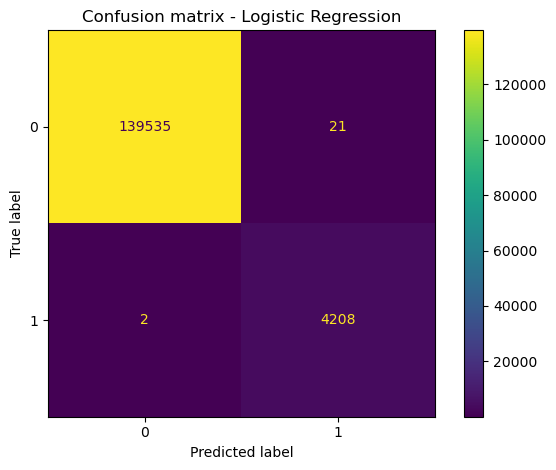

Type               25.655543
total_count        17.303989
E3                -11.477819
E4                 -6.782326
unique_events       6.259743
E23                -4.499054
max_event_count     4.151283
E2                 -3.558750
log_total          -1.696812
E26                -1.657364
E21                -1.042888
E5                 -0.918798
E6                 -0.584639
E11                -0.569578
E9                 -0.569031
dtype: float64

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay

feat_cols = core + top_events 
X = df_feat[feat_cols].astype(float)
y = df_feat["y"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

clf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced")),
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("           ===== Classification Report =====")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix - Logistic Regression")
plt.tight_layout()
plt.show()

# Importance approx: coefficients
coefs = clf.named_steps["logreg"].coef_.ravel()
imp = pd.Series(coefs, index=feat_cols).sort_values(key=np.abs, ascending=False).head(15)
imp
